## Notebook Description

This notebook is an exploration of the next steps proposed in my Readme.  There are minimal descriptions of code.

### Next steps

- Drop outliers and rerun models
- If scores don't improve find more data and engineer more features than were made previously
- Run models again and find which models are best

In [33]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import requests
import json
import warnings
import pickle
import random
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

from tqdm import tqdm
from time import sleep
from io import BytesIO
from datetime import datetime
from igdb.wrapper import IGDBWrapper
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import  mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [3]:
sglobal = pd.read_csv('../Data/vgsalesGlobale2.csv')
sglobal.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [4]:
sglobal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
Rank            16598 non-null int64
Name            16598 non-null object
Platform        16598 non-null object
Year            16327 non-null float64
Genre           16598 non-null object
Publisher       16540 non-null object
NA_Sales        16598 non-null float64
EU_Sales        16598 non-null float64
JP_Sales        16598 non-null float64
Other_Sales     16598 non-null float64
Global_Sales    16598 non-null float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


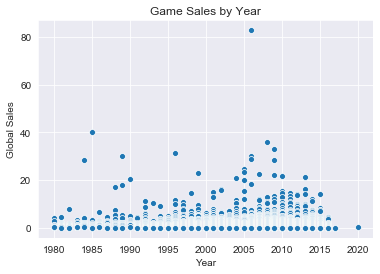

In [5]:
sns.set_style('darkgrid')
sns.scatterplot(sglobal.Year, sglobal.Global_Sales);
plt.title('Game Sales by Year')
plt.ylabel('Global Sales')
plt.show()

#### Dropping columns

In [6]:
# Name column will be dropped later
sglobal.drop(columns=['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Rank'], axis=1, inplace=True)
sglobal.head()

,Name,Platform,Year,Genre,Publisher,Global_Sales
0,Wii Sports,Wii,2006.0,Sports,Nintendo,82.74
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35.82
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,33.00
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,31.37


#### Dropping individual datapoints

In [7]:
sglobal.drop(index=[0, 1, 5957], inplace = True)

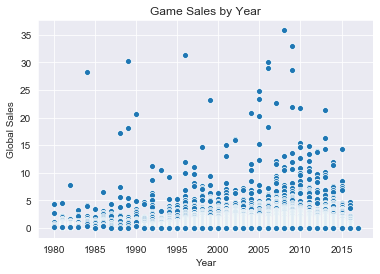

In [8]:
sns.set_style('darkgrid')
sns.scatterplot(sglobal.Year, sglobal.Global_Sales)
plt.title('Game Sales by Year')
plt.ylabel('Global Sales')
plt.show();

#### Dropping NaN values

In [9]:
sglobal.dropna(inplace=True)
sglobal.isna().sum()

Name            0
Platform        0
Year            0
Genre           0
Publisher       0
Global_Sales    0
dtype: int64

#### Creating another feature

In [10]:
remake = np.array(sglobal['Name'].duplicated())
remake_df = pd.DataFrame(remake, columns=['Remake'], index=sglobal.index)
remake_df.head()

,Remake
2,False
3,False
4,False
5,False
6,False


In [11]:
sglobal = pd.concat((sglobal,remake_df), axis=1)
sglobal.head()

,Name,Platform,Year,Genre,Publisher,Global_Sales,Remake
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35.82,False
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,33.00,False
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,31.37,False
5,Tetris,GB,1989.0,Puzzle,Nintendo,30.26,False
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,30.01,False


In [12]:
sglobal['Remake'] = sglobal['Remake'].astype(int)
sglobal.head()

,Name,Platform,Year,Genre,Publisher,Global_Sales,Remake
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35.82,0
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,33.00,0
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,31.37,0
5,Tetris,GB,1989.0,Puzzle,Nintendo,30.26,0
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,30.01,0


In [13]:
sglobal_nn = sglobal.drop('Name', axis='columns')
sglobal.head()

,Name,Platform,Year,Genre,Publisher,Global_Sales,Remake
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35.82,0
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,33.00,0
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,31.37,0
5,Tetris,GB,1989.0,Puzzle,Nintendo,30.26,0
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,30.01,0


#### Removing Outliers

In [45]:
sglobal_nn.Global_Sales.describe()

count    16288.000000
mean         0.533442
std          1.394756
min          0.010000
25%          0.060000
50%          0.170000
75%          0.480000
max         35.820000
Name: Global_Sales, dtype: float64

In [41]:
mean = sglobal_nn.mean()
stddev = sglobal_nn.std()
cutoff = stddev*3
lowrange = mean - cutoff
upperrange = mean + cutoff

In [54]:
sglobal_nooutliers = sglobal_nn.loc[(sglobal_nn['Global_Sales'] > lowrange) & (sglobal_nn['Global_Sales'] < upperrange)]
sglobal_nooutliers.head()

,Platform,Year,Genre,Publisher,Global_Sales,Remake
224,PS2,2003.0,Racing,Vivendi Games,4.70,0
225,PS,2000.0,Sports,Activision,4.68,0
226,Wii,2008.0,Simulation,Nintendo,4.68,0
227,PS2,2002.0,Action,Electronic Arts,4.67,0
228,X360,2011.0,Racing,Microsoft Game Studios,4.64,0


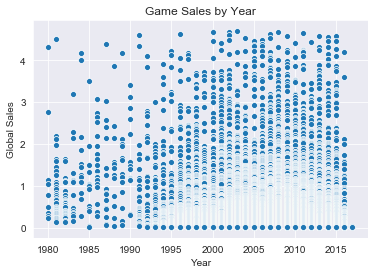

In [71]:
sns.set_style('darkgrid')
sns.scatterplot(sglobal_nooutliers.Year, sglobal_nooutliers.Global_Sales)
plt.title('Game Sales by Year')
plt.ylabel('Global Sales')
plt.show();

## Coding the first model series

In [58]:
y = sglobal_nooutliers['Global_Sales']
X = sglobal_nooutliers.drop('Global_Sales', axis=1)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)

In [60]:
# OneHotEncoding X_train and X_test columns

ohe = OneHotEncoder(handle_unknown='ignore')

ohe.fit(X_train[['Platform', 'Genre', 'Publisher']])

ohe_cats = pd.DataFrame(ohe.transform(X_train[['Platform', 'Genre', 'Publisher']]).todense(), 
                        columns=ohe.get_feature_names(),index=X_train.index)

ohe_cats_test= pd.DataFrame(ohe.transform(X_test[['Platform', 'Genre', 'Publisher']]).todense(), 
                        columns=ohe.get_feature_names(),index=X_test.index)


In [61]:
# Dropping the unnecessary columns
X_train.drop(columns=['Platform', 'Genre', 'Publisher'], axis=1, inplace=True)
X_test.drop(columns=['Platform', 'Genre', 'Publisher'], axis=1, inplace=True)

In [62]:
# Concatenating the one hotted columns
X_train_ohe = pd.concat((X_train, ohe_cats), axis=1)
X_test_ohe = pd.concat((X_test, ohe_cats_test), axis=1)

In [63]:
X_train_ohe.head()

,Year,Remake,x0_2600,x0_3DO,x0_3DS,x0_DC,x0_DS,x0_GB,x0_GBA,x0_GC,...,x2_Zoo Games,x2_Zushi Games,x2_bitComposer Games,x2_dramatic create,x2_fonfun,x2_iWin,x2_id Software,x2_imageepoch Inc.,x2_inXile Entertainment,x2_responDESIGN
7696,2005.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10098,2014.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10752,2015.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
854,2002.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5699,2015.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
X_test_ohe.head()

,Year,Remake,x0_2600,x0_3DO,x0_3DS,x0_DC,x0_DS,x0_GB,x0_GBA,x0_GC,...,x2_Zoo Games,x2_Zushi Games,x2_bitComposer Games,x2_dramatic create,x2_fonfun,x2_iWin,x2_id Software,x2_imageepoch Inc.,x2_inXile Entertainment,x2_responDESIGN
3363,2001.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12438,2011.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16036,2016.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9245,2010.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12160,2011.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
ss = StandardScaler()

X_train_ohe_ss = ss.fit_transform(X_train_ohe)
X_test_ohe_ss = ss.transform(X_test_ohe)

### Linear Regression

In [66]:
random.seed(a=42)
linreg = LinearRegression()

linreg.fit(X_train_ohe_ss, y_train)

print(linreg.score(X_train_ohe_ss, y_train))
print(mean_absolute_error(y_train, linreg.predict(X_train_ohe_ss)))

0.2407988632576491
0.3360606312474865


In [67]:
cross_val_score(linreg, X_train_ohe_ss, y_train, cv=3)

array([-1.25626570e+28, -1.49620003e+28, -3.37633158e+28])

In [68]:
print(linreg.score(X_test_ohe_ss, y_test))
print(mean_absolute_error(y_test, linreg.predict(X_test_ohe_ss)))

-2.5231628446080588e+23
42422610630.96716


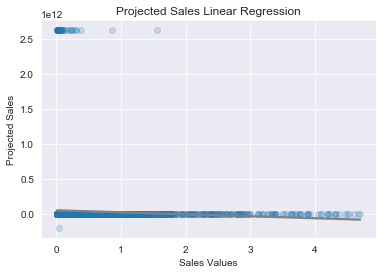

In [69]:
sns.regplot(y_test, linreg.predict(X_test_ohe_ss), ci=False, 
            scatter_kws={'alpha': 0.2}, line_kws={"color": "grey"})
plt.title('Projected Sales Linear Regression')
plt.xlabel('Sales Values')
plt.ylabel('Projected Sales')

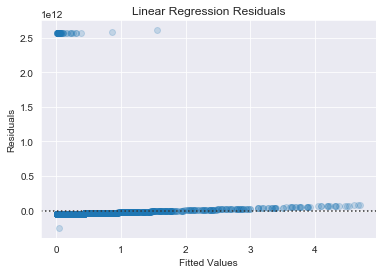

In [70]:
sns.residplot(y_test, linreg.predict(X_test_ohe_ss), scatter_kws={'alpha': 0.2})
plt.title('Linear Regression Residuals')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

### Ridge Regression

In [72]:
ridge = Ridge(alpha=4, random_state=42)

ridge.fit(X_train_ohe_ss, y_train)
print(ridge.score(X_train_ohe_ss, y_train))
print(mean_absolute_error(y_train, ridge.predict(X_train_ohe_ss)))

0.2409107654383228
0.3365842509474202


In [73]:
cross_val_score(ridge, X_train_ohe_ss, y_train, cv = 3).mean()

0.20888129291547675

In [74]:
print(ridge.score(X_test_ohe_ss, y_test))
print(mean_absolute_error(y_test, ridge.predict(X_test_ohe_ss)))

0.19636799246795777
0.35650465992350855


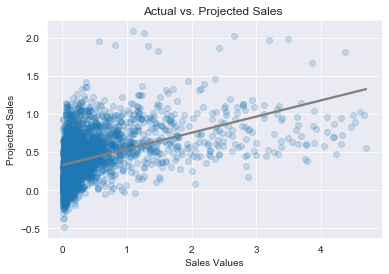

In [75]:
sns.regplot(y_test, ridge.predict(X_test_ohe_ss), ci=False, 
            scatter_kws={'alpha': 0.2}, line_kws={"color": "grey"})
plt.title('Actual vs. Projected Sales ')
plt.xlabel('Sales Values')
plt.ylabel('Projected Sales');

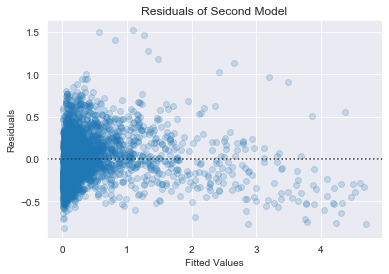

In [76]:
sns.residplot(y_test, ridge.predict(X_test_ohe_ss), scatter_kws={'alpha': 0.2})
plt.title('Residuals of Second Model')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals');

### Lasso Regression

In [89]:
lasso = Lasso(alpha= .0001)

lasso.fit(X_train_ohe_ss, y_train) 
print(lasso.score(X_train_ohe_ss, y_train))
print(mean_absolute_error(y_train, lasso.predict(X_train_ohe_ss)))

0.24089400197806188
0.33650176741973353


## Data Collection

In [67]:
!pip install igdb-api-v4 #Installs the wrapper

To collect data from [IGDB](pi-docs.igdb.com/#about) create a twitch account.  If the instructions are follwed at the account creation site for Twitch.tv there shouldn't be a major problem.  When filling in the application the OAuth url was set as "http://localhost" to let the system know the data will be run locally then choose analytics tool from the category menu.  Once the application is accepted  a client ID is assigned to you and you can ask for a client secret.  Though this secret is used in the code to collect the data it should not be made public. As such once the code has been run it should be written down or saved to the computer and then deleted from the code.  Once the client ID and client secret have been collected an access token will be needed to collect the data from IGDB.  The request URL is found under the authentification section of the instructions and the client ID and client secret can be filled in to make a successful request.  A wrapper was created to deliver the data in a format comptible with python under wrappers, however, the readme file that shows how to run the data contains an issue that throws an error.  The solution can be found in a discussion entitled 'Main Readme Example Does Not Work' under the issues tab.  

In [29]:
# Don't upload your client secret
client_ID = 'ryht2y9jvswue4yv5ddm894h7qvxdn'
client_secret = # Removed for security reasons!

r = requests.post(f"https://id.twitch.tv/oauth2/token?client_id={client_ID}&client_secret={client_secret}&grant_type=client_credentials")
access_token = json.loads(r._content)['access_token']
wrapper = IGDBWrapper(client_ID, access_token)

In [30]:
# converts the information collected with the wrapper into JSON format
def bytes_to_json(byte_array):
    _  = BytesIO(byte_array)
    return json.loads(_.read())

The data collected was for the games in the sglobal dataset so the names of the games were used to identify which game data should be returned.  This did not mean that the website would have data on all the games requested so a try/except was set up to allow the request to return None if there was no data so that the request would not throw an error if there were a NaN value.  The final issue to consider when working with this API is that the rate limit for requests is four per second.  For this reason, a counter was set up to space out the information returned which told the machine to wait if it thought the rate would exceed the limit.

In [67]:
now = datetime.now
window_open=now()
count=0
data=[]
with tqdm(total=len(sglobal)) as pbar:
    for name in sglobal.Name:
        try:
            byte_array = wrapper.api_request(
                    'games',
                    f'fields *; where name = "{name}";'
            )
            game_info = bytes_to_json(byte_array)
            if not game_info:
                game_info=[None]
        except:
            game_info=[None]

        data.append(game_info[0])
        # the rate monitor
        count+=1
        if count % 4 == 0:
            window_close=now()
            difference= window_close-window_open
            if difference.total_seconds() <= 1:
                sleep(1)
            window_open=now()
        pbar.update(1)

#### Pickling 

In [32]:
# Running this cell saves an instance of the collected data
filename = 'Igdb_data'
outfile = open(filename, 'wb')

pickle.dump(data, outfile)
outfile.close()

In [90]:
# Running this cell will import the collected data if there is a problem
infile = open('Igdb_data','rb')
new_data = pickle.load(infile)
infile.close()

## Creating new features

In [91]:
valid_data = [] 
for val in new_data: 
    if val != None : 
        valid_data.append(val)

In [92]:
pd.set_option('display.max_columns', None)
new_cols = pd.DataFrame(valid_data)
new_cols.drop_duplicates(subset='id', inplace=True)
new_cols['id'].value_counts()

67583     1
78349     1
122249    1
1418      1
11663     1
         ..
2764      1
717       1
4815      1
69164     1
20482     1
Name: id, Length: 7716, dtype: int64

In [93]:
new_cols.head()

,id,age_ratings,aggregated_rating,aggregated_rating_count,alternative_names,bundles,category,collection,cover,created_at,external_games,first_release_date,follows,game_modes,genres,involved_companies,keywords,name,platforms,player_perspectives,rating,rating_count,release_dates,screenshots,similar_games,slug,summary,tags,themes,total_rating,total_rating_count,updated_at,url,videos,websites,checksum,franchise,franchises,storyline,multiplayer_modes,artworks,game_engines,standalone_expansions,hypes,dlcs,expansions,status,version_parent,version_title,parent_game
0,2181,"[189, 26427]",75.00,3.0,[32754],"[130310, 136311]",0,681.0,86110.0,1372204800,"[35583, 144876, 221465, 245925, 1928625, 19289...",1.163894e+09,34.0,"[1, 2, 4]","[13, 14]","[4658, 22251]","[20, 30, 56, 274, 299, 311, 632, 977, 992, 116...",Wii Sports,[5],"[1, 2]",75.232386,188.0,"[27256, 27257, 27258, 27259]","[10247, 10248, 10249, 10250, 10251, 178474, 17...","[1244, 1352, 2182, 2185, 2186, 2194, 3915, 488...",wii-sports,Bowl like a pro or go for that home run...\nEx...,"[40, 268435469, 268435470, 536870932, 53687094...",[40],75.116193,191.0,1605484800,https://www.igdb.com/games/wii-sports,[1276],"[570, 125920]",7dd08287-257b-4b94-589c-ee707af7c003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,358,"[24, 24927]",NaN,NaN,"[31808, 31809, 31810, 31811, 31812, 31813, 31814]","[5199, 9250, 69638, 77227, 77785]",0,6118.0,97418.0,1300320000,"[30094, 142871, 190087, 220718, 1611061]",4.954176e+08,363.0,"[1, 2]","[8, 31]","[97362, 97363]","[16, 137, 226, 296, 394, 432, 558, 594, 846, 1...",Super Mario Bros.,"[5, 18, 24, 37, 41, 51, 130, 307]",[4],83.849890,802.0,"[143761, 143763, 143764, 143765, 143766, 14376...","[379065, 379066, 379067, 379068, 379069]","[1067, 1068, 1075, 1078, 1079, 2180, 3340, 334...",super-mario-bros,A side scrolling 2D platformer and first entry...,"[1, 268435464, 268435487, 536870928, 536871049...",[1],83.849890,802.0,1606003200,https://www.igdb.com/games/super-mario-bros,"[35300, 35301]","[4549, 4550]",58df069e-1ee1-a548-2f21-673729e6239d,24.0,"[24, 845]","One day, the Mushroom Kingdom was invaded by t...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2183,"[192, 13218]",71.25,5.0,"[34468, 34469, 34470, 34471, 34472, 44750]",NaN,0,449.0,94766.0,1372204800,"[35546, 138281, 189061, 218733, 245265, 192841...",1.207786e+09,93.0,"[1, 2, 4]",[10],"[4656, 98978]","[25, 280, 350, 2071, 3627, 3863, 4157, 4350, 4...",Mario Kart Wii,[5],[2],80.073724,304.0,"[134832, 195800, 195801, 195802]","[384196, 384197, 384198, 384199, 384200, 38420...","[1074, 1077, 2344, 2349, 2350, 3772, 79812, 11...",mario-kart-wii,Mario Kart Wii is a multiplayer-oriented racin...,"[1, 27, 40, 268435466, 536870937, 536871192, 5...","[1, 27, 40]",75.661862,309.0,1606003200,https://www.igdb.com/games/mario-kart-wii,"[1279, 35952]","[573, 52385]",71b06794-6c39-a2eb-d468-c9e7bee35708,24.0,"[24, 845]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2182,"[190, 13213]",90.00,5.0,"[32755, 34781, 44953]","[130310, 136311]",0,681.0,112516.0,1372204800,"[35588, 72979, 137871, 221471, 251440, 1928534...",1.248394e+09,19.0,"[1, 2, 4]",[14],"[51540, 51541]","[30, 58, 227, 274, 299, 374, 598, 613, 640, 66...",Wii Sports Resort,[5],"[1, 2]",79.216604,79.0,"[4514, 144836, 144837]","[27118, 178517, 178518, 178519, 178520, 178521...","[534, 660, 1352, 2181, 2185, 2189, 4881, 18238...",wii-sports-resort,Set off on a journey to a tropical island wher...,"[40, 268435470, 536870942, 536870970, 53687113...",[40],84.608302,84.0,1605484800,https://www.igdb.com/games/wii-sports-resort,"[1277, 39358]","[571, 52375]",12e5b4d6-09e3-18dc-1b43-3e5984c1a4fe,NaN,NaN,NaN,[1911],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,130749,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,1582329600,[1857140],NaN,NaN,NaN,NaN,NaN,NaN,Tetris,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tetris--4,NaN,NaN,NaN,NaN,NaN,1582329600,https://www.igdb.com/games/tetris--4,NaN,NaN,ffe01570-c774-c11c-dc9e-652f52519e13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [94]:
cols_toadd = new_cols[['name','total_rating','platforms', 'similar_games', 'collection']]

In [95]:
new_df = sglobal.merge(cols_toadd, left_on='Name', right_on='name')
new_df.head()

,Name,Platform,Year,Genre,Publisher,Global_Sales,Remake,name,total_rating,platforms,similar_games,collection
0,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35.82,0,Mario Kart Wii,75.661862,[5],"[1074, 1077, 2344, 2349, 2350, 3772, 79812, 11...",449.0
1,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,33.00,0,Wii Sports Resort,84.608302,[5],"[534, 660, 1352, 2181, 2185, 2189, 4881, 18238...",681.0
2,Tetris,GB,1989.0,Puzzle,Nintendo,30.26,0,Tetris,NaN,NaN,NaN,NaN
3,Tetris,NES,1988.0,Puzzle,Nintendo,5.58,1,Tetris,NaN,NaN,NaN,NaN
4,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,30.01,0,New Super Mario Bros.,88.673926,"[20, 41]","[358, 1068, 1078, 1079, 2180, 2191, 3340, 3349...",6124.0


In [96]:
new_df.drop('name', axis=1, inplace=True)

In [97]:
# This function will translate the entries into counts of iterables creating meaningful entries in the dataframe
def list_to_count(record):
    if type(record)==list:
        return len(record)
    else:
        return 0

In [98]:
new_df['platforms'] = new_df['platforms'].apply(list_to_count)

In [99]:
new_df['similar_games'] = new_df['similar_games'].apply(list_to_count)

In [100]:
new_df['collection'] = new_df['collection'].apply(list_to_count)

In [101]:
new_df.head()

,Name,Platform,Year,Genre,Publisher,Global_Sales,Remake,total_rating,platforms,similar_games,collection
0,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35.82,0,75.661862,1,9,0
1,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,33.00,0,84.608302,1,9,0
2,Tetris,GB,1989.0,Puzzle,Nintendo,30.26,0,NaN,0,0,0
3,Tetris,NES,1988.0,Puzzle,Nintendo,5.58,1,NaN,0,0,0
4,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,30.01,0,88.673926,2,9,0


In [102]:
new_df.dropna(inplace=True)

In [103]:
new_df.head()

,Name,Platform,Year,Genre,Publisher,Global_Sales,Remake,total_rating,platforms,similar_games,collection
0,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35.82,0,75.661862,1,9,0
1,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,33.00,0,84.608302,1,9,0
4,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,30.01,0,88.673926,2,9,0
5,Wii Play,Wii,2006.0,Misc,Nintendo,29.02,0,63.073819,1,9,0
6,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,28.62,0,81.720034,2,9,0


## Coding the second model series

In [104]:
y = new_df['Global_Sales']
X = new_df.drop('Global_Sales', axis=1)

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [106]:
ohe = OneHotEncoder(handle_unknown='ignore')

ohe.fit(X_train[['Platform', 'Genre', 'Publisher']])

ohe_cats = pd.DataFrame(ohe.transform(X_train[['Platform', 'Genre', 'Publisher']]).todense(), 
                        columns=ohe.get_feature_names(),index=X_train.index)

ohe_cats_test= pd.DataFrame(ohe.transform(X_test[['Platform', 'Genre', 'Publisher']]).todense(), 
                        columns=ohe.get_feature_names(),index=X_test.index)

In [107]:
X_train.drop(columns=['Platform', 'Genre', 'Publisher', 'Name'], axis=1, inplace=True)
X_test.drop(columns=['Platform', 'Genre', 'Publisher','Name'], axis=1, inplace=True)

In [108]:
X_train_ohe = pd.concat((X_train, ohe_cats), axis=1)
X_test_ohe = pd.concat((X_test, ohe_cats_test), axis=1)

In [109]:
X_train_ohe.shape

(6464, 347)

In [110]:
X_test_ohe.head()

,Year,Remake,total_rating,platforms,similar_games,collection,x0_2600,x0_3DO,x0_3DS,x0_DC,x0_DS,x0_GB,x0_GBA,x0_GC,x0_GEN,x0_N64,x0_NES,x0_NG,x0_PC,x0_PS,x0_PS2,x0_PS3,x0_PS4,x0_PSP,x0_PSV,x0_SAT,x0_SNES,x0_WS,x0_Wii,x0_WiiU,x0_X360,x0_XB,x0_XOne,x1_Action,x1_Adventure,x1_Fighting,x1_Misc,x1_Platform,x1_Puzzle,x1_Racing,x1_Role-Playing,x1_Shooter,x1_Simulation,x1_Sports,x1_Strategy,x2_10TACLE Studios,x2_1C Company,x2_2D Boy,x2_3DO,x2_49Games,x2_505 Games,x2_5pb,x2_989 Studios,x2_AQ Interactive,x2_ASCII Entertainment,x2_Acclaim Entertainment,x2_Accolade,x2_Ackkstudios,x2_Acquire,x2_Activision,x2_Activision Value,x2_Adeline Software,x2_Agatsuma Entertainment,x2_Aksys Games,x2_Alawar Entertainment,x2_Alternative Software,x2_Altron,x2_Answer Software,x2_Aqua Plus,x2_Arc System Works,x2_Arena Entertainment,x2_Arika,x2_ArtDink,x2_Ascaron Entertainment GmbH,x2_Aspyr,x2_Astragon,x2_Asylum Entertainment,x2_Atari,x2_Atlus,x2_Avalon Interactive,x2_Avanquest,x2_Avanquest Software,x2_BAM! Entertainment,x2_BMG Interactive Entertainment,x2_Banpresto,x2_Bethesda Softworks,x2_Big Ben Interactive,x2_Bigben Interactive,x2_Black Bean Games,x2_Blue Byte,x2_Brash Entertainment,x2_CDV Software Entertainment,x2_CTO SpA,x2_Capcom,x2_Cave,x2_City Interactive,x2_Cloud Imperium Games Corporation,x2_Codemasters,x2_Codemasters Online,x2_Coleco,x2_Compile,x2_Compile Heart,x2_Conspiracy Entertainment,x2_Core Design Ltd.,x2_Crave Entertainment,x2_Crimson Cow,x2_Crystal Dynamics,x2_D3Publisher,x2_DHM Interactive,x2_DTP Entertainment,x2_Daedalic,x2_Daedalic Entertainment,x2_Data Design Interactive,x2_Deep Silver,"x2_Destination Software, Inc",x2_Destineer,x2_Devolver Digital,x2_Disney Interactive Studios,x2_DreamCatcher Interactive,x2_Dusenberry Martin Racing,x2_EA Games,x2_ESP,x2_Eidos Interactive,x2_Electronic Arts,x2_Electronic Arts Victor,x2_Empire Interactive,x2_Encore,x2_Enix Corporation,x2_Enterbrain,x2_Epic Games,x2_Ertain,x2_Essential Games,x2_Evolved Games,x2_Excalibur Publishing,x2_Falcom Corporation,x2_Focus Home Interactive,x2_Fox Interactive,x2_From Software,x2_FuRyu,x2_FuRyu Corporation,x2_Funbox Media,x2_Funsta,x2_GOA,x2_GSP,x2_GT Interactive,x2_Game Factory,x2_Gamebridge,x2_Gamecock,x2_Gameloft,x2_Gathering of Developers,x2_Genki,x2_Ghostlight,x2_Global Star,x2_Graffiti,x2_Gremlin Interactive Ltd,x2_Groove Games,x2_GungHo,x2_Gust,x2_HAL Laboratory,x2_HMH Interactive,x2_Harmonix Music Systems,x2_Hasbro Interactive,x2_Havas Interactive,x2_Headup Games,x2_Hello Games,x2_Hip Interactive,x2_Hudson Entertainment,x2_Hudson Soft,x2_Human Entertainment,x2_Iceberg Interactive,x2_Idea Factory,x2_Idea Factory International,x2_Ignition Entertainment,x2_Illusion Softworks,x2_Indie Games,x2_Infogrames,x2_Insomniac Games,x2_Interplay,x2_Interplay Productions,x2_Introversion Software,x2_JVC,x2_Jaleco,x2_JoWood Productions,x2_Just Flight,x2_Kadokawa Shoten,x2_Kalypso Media,x2_Kando Games,x2_Kemco,x2_Koch Media,x2_Konami Digital Entertainment,x2_LEGO Media,x2_LSP Games,x2_Laguna,x2_Level 5,x2_Lighthouse Interactive,x2_Little Orbit,x2_LucasArts,x2_MC2 Entertainment,x2_MTV Games,x2_Mad Catz,x2_Majesco Entertainment,x2_Mamba Games,x2_Marvelous Entertainment,x2_Marvelous Interactive,x2_Mastertronic,x2_Mastiff,x2_Mattel Interactive,x2_Maxis,x2_MediaQuest,x2_Metro 3D,x2_Micro Cabin,x2_Microids,x2_Microprose,x2_Microsoft Game Studios,x2_Midas Interactive Entertainment,x2_Midway Games,x2_Milestone S.r.l.,x2_Mindscape,x2_Mojang,x2_Moss,x2_Mumbo Jumbo,x2_Myelin Media,x2_NCSoft,x2_NDA Productions,x2_NEC Interchannel,x2_Namco Bandai Games,x2_Natsume,x2_Navarre Corp,x2_Nihon Falcom Corporation,x2_Nintendo,x2_Nippon Ichi Software,x2_Nitroplus,x2_Nobilis,x2_Nordic Games,x2_NovaLogic,x2_Number None,x2_O-Games,x2_O3 Entertainment,x2_Ocean,x2_Origin Systems,x2_Oxygen Interactive,x2_PQube,x2_Pack In Soft,x2_Palcom,x2_Paradox Interactive,x2_Parker Bros.,x2_Performance Designed Products,x2_Phantom EFX,x2_Pinnacle,x2_Play It,x2_Playlogic Game Factory,x2_Playmore,x2_PopCap Games,x2_PopT

In [116]:
ss = StandardScaler()

X_train_ndf_ss = ss.fit_transform(X_train_ohe)
X_test_ndf_ss = ss.transform(X_test_ohe)

### Linear Regression

In [149]:
random.seed(a=42)
linreg = LinearRegression()

linreg.fit(X_train_ndf_ss, y_train)
print(linreg.score(X_train_ndf_ss, y_train))
print(mean_absolute_error(y_train, linreg.predict(X_train_ndf_ss)))

0.1881728697894609
0.6842872590069279


In [150]:
cross_val_score(linreg, X_train_ndf_ss, y_train, cv=3).mean()

-6.255082441732036e+28

In [151]:
print(linreg.score(X_test_ndf_ss, y_test))
print(mean_absolute_error(y_test, linreg.predict(X_test_ndf_ss)))

-3.0022426137219882e+22
28582644966.53013


### Ridge Regression

In [148]:
ridge = Ridge(alpha=4.0, random_state=42)

ridge.fit(X_train_ndf_ss, y_train)
print(ridge.score(X_train_ndf_ss, y_train))
print(mean_absolute_error(y_train, ridge.predict(X_train_ndf_ss)))

0.18849331182661233
0.6823526966933955


In [147]:
cross_val_score(ridge, X_train_ndf_ss, y_train, cv=3).mean()

0.162527847937306

In [152]:
print(ridge.score(X_test_ndf_ss, y_test))
print(mean_absolute_error(y_test, ridge.predict(X_test_ndf_ss)))

0.23582534555202583
0.68929752601618


### Random Forest Regressor

In [111]:
rfr = RandomForestRegressor(random_state=42, max_depth=30, max_features=50, min_samples_split=20,)

rfr.fit(X_train_ohe, y_train)

print(rfr.score(X_train_ohe, y_train))
print(mean_absolute_error(y_train, rfr.predict(X_train_ohe)))

0.45427334114507045
0.493706755494481


In [112]:
cross_val_score(rfr, X_train_ohe, y_train, cv=3).mean()

0.24928257309037472

In [113]:
print(rfr.score(X_test_ohe, y_test))
print(mean_absolute_error(y_test, rfr.predict(X_test_ohe)))

0.36324174494594264
0.5806616148170312


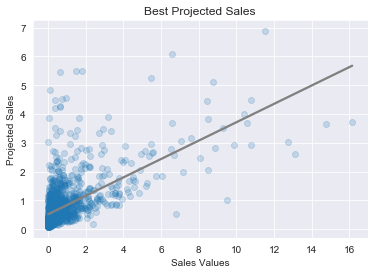

In [114]:
sns.regplot(y_test, rfr.predict(X_test_ohe), ci=False, 
            scatter_kws={'alpha': 0.2}, line_kws={"color": "grey"})
plt.title('Best Projected Sales')
plt.xlabel('Sales Values')
plt.ylabel('Projected Sales');

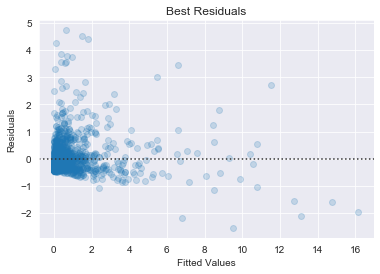

In [115]:
sns.residplot(y_test, rfr.predict(X_test_ohe), scatter_kws={'alpha': 0.2})
plt.title('Best Residuals')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.savefig('ResidRFR')